In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# Summary
With this dataset, I try to answer the below three questions:
1. How are Total ESG Scores measured from the individual E/S/G ratings?
- Which sectors and subindustries are among the best and worst performers in terms of ESG risks?
- Can controversies scores be predicted using a linear regression machine learning model based on ESG scores and industries?
- Are there any geographical patterns of controversy scores among S&P 500 firms?

## Part II. Assessing Data

In [2]:
#Loading ESG scores
esg = pd.read_csv('Data/esg_score.csv')
esg.head()

,Unnamed: 0,Total ESG Score,Environment,Social,Governance,Controversy Score
0,MMM,35,12.8,14.0,8.4,3
1,ABT,30,3.0,16.2,10.6,3
2,ABBV,29,0.6,17.1,11.3,3
3,ACN,11,0.6,5.0,5.8,2
4,ATVI,17,0.2,10.7,6.2,2


In [3]:
#Loading firm info
firms = pd.read_csv('Data/firm_info.csv')
firms.head()

,Unnamed: 0,ticker,Sector,Industry,Headquarter
0,0,MMM,Industrials,Industrial Conglomerates,"St. Paul, Minnesota"
1,1,ABT,Health Care,Health Care Equipment,"North Chicago, Illinois"
2,2,ABBV,Health Care,Pharmaceuticals,"North Chicago, Illinois"
3,3,ABMD,Health Care,Health Care Equipment,"Danvers, Massachusetts"
4,4,ACN,Information Technology,IT Consulting & Other Services,"Dublin, Ireland"


## Part III. Cleaning Data

In [4]:
#Renaming first column
esg = esg.rename(columns={'Unnamed: 0': 'Ticker'})
firms = firms.rename(columns={'ticker':'Ticker'})

In [5]:
#Concatenating the two data frames
df = pd.merge(firms, esg, on='Ticker') 

In [6]:
#Dropping redundant index column
df = df.drop(columns=['Unnamed: 0'])
df.head()

,Ticker,Sector,Industry,Headquarter,Total ESG Score,Environment,Social,Governance,Controversy Score
0,MMM,Industrials,Industrial Conglomerates,"St. Paul, Minnesota",35,12.8,14.0,8.4,3
1,ABT,Health Care,Health Care Equipment,"North Chicago, Illinois",30,3.0,16.2,10.6,3
2,ABBV,Health Care,Pharmaceuticals,"North Chicago, Illinois",29,0.6,17.1,11.3,3
3,ACN,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",11,0.6,5.0,5.8,2
4,ATVI,Communication Services,Interactive Home Entertainment,"Santa Monica, California",17,0.2,10.7,6.2,2


In [7]:
#Checking for null values
np.sum(df.isnull())

Ticker               0
Sector               0
Industry             0
Headquarter          0
Total ESG Score      0
Environment          0
Social               0
Governance           0
Controversy Score    0
dtype: int64

In [8]:
#Checking for duplicates
np.sum(df.duplicated())

0

In [9]:
df.shape

(452, 9)

In [10]:
#Saving the CSV file for Tableau analysis
df.to_csv('Data/df.csv')

## Part IV. Analysis
This part starts with an overview of all the numeric data and then goes on to explore the scores at sectorial and subindustrial levels, which can potentially help with industry tilts strategy. 

In [11]:
#Overview 
df.describe()

,Total ESG Score,Environment,Social,Governance,Controversy Score
count,452.000000,452.000000,452.000000,452.000000,452.000000
mean,22.579646,5.649336,9.854425,7.069690,1.918142
std,7.423540,5.470771,3.977459,2.425673,0.960381
min,9.000000,0.000000,1.000000,3.000000,0.000000
25%,17.000000,1.500000,7.000000,5.075000,1.000000
50%,22.000000,4.000000,9.650000,6.300000,2.000000
75%,27.000000,9.000000,12.225000,8.200000,2.250000
max,50.000000,24.600000,24.000000,15.200000,5.000000


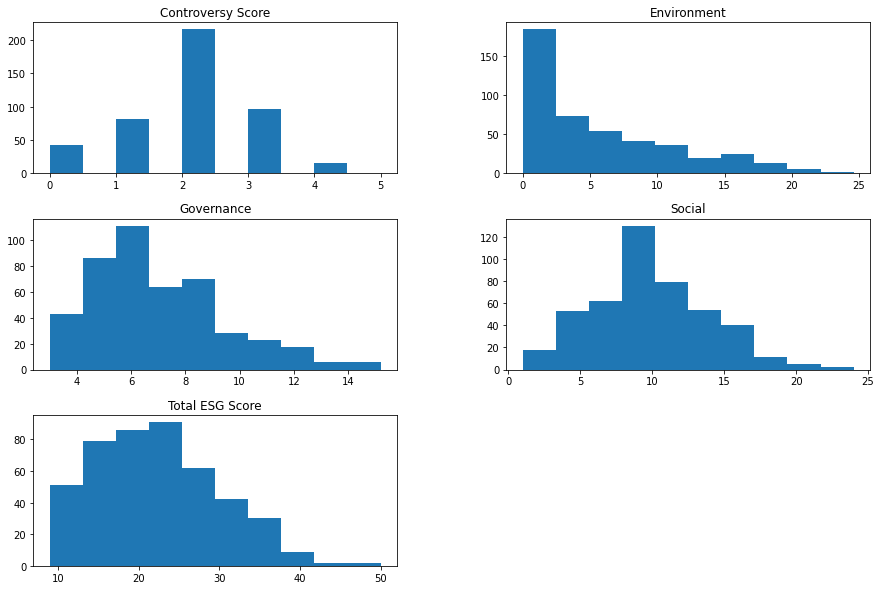

In [12]:
#Overview of numerical data distributions
esg.hist(grid=False, figsize=(15, 10));
plt.savefig('Data/hist.jpg', quality=95, bbox_inches='tight')

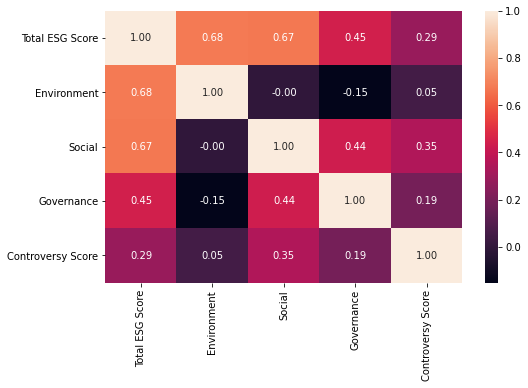

In [13]:
#Heatmap of numerical columns, most interested in the potentially correlated columns of Total ESG Score and Controversy Score
plt.figure(figsize=(8, 5))
sns.heatmap(esg.corr(), annot=True, fmt='.2f');
plt.savefig('Data/output.jpg', quality=95, bbox_inches='tight')

From the heatmap below, it appears that the E and S factors are much stronger correlated to the score than governance, with correlations of 0.68 and 0.67 respectively, while the G factor is only at 0.45. This means, although controversy score is based on ESG-perspective incidents/events, no single score is directly correlated with the final score. 

### Industry Tilt Strategy
To answer question one, which sectors and subindustries are among the best and worst performers in terms of ESG risks, I used `groupby()` sectors and curated the mean scores. 

In [14]:
#Creating a DataFrame that aggregates average scores per sector
sector_overview = df.groupby(['Sector'], sort=False).mean()

In [15]:
#Styler
cm = sns.light_palette("blue", as_cmap=True)

s = sector_overview.style.background_gradient(cmap=cm, high=0)
s

,Total ESG Score,Environment,Social,Governance,Controversy Score
Sector,,,,,
Industrials,25.523810,7.163492,11.833333,6.587302,1.825397
Health Care,23.175439,2.015789,13.049123,8.156140,2.140351
Information Technology,17.590909,3.065152,8.075758,6.260606,1.378788
Communication Services,19.944444,1.338889,10.483333,8.300000,2.444444
Consumer Discretionary,19.310345,4.425862,9.094828,5.839655,2.206897
Utilities,30.592593,14.555556,10.144444,5.974074,2.185185
Financials,22.666667,1.520000,10.515000,10.545000,2.033333
Materials,26.913043,13.404348,7.191304,6.439130,2.043478
Real Estate,14.034483,4.196552,4.527586,5.158621,0.689655


**Conclusion:** The data shows that, real estate, information technology and consumer discretionary are among the best (lowest ESG scores), while energy, utilities, and materials ranked highest in terms of overall ESG risks. Interestingly, although overall environmental scores are the dominant factor of high total ESG scores, there are some high overall risk are mostly a result of high social or governance scores, such as healthcare, financials and communication services. 

## Part V. Modelling
To proceed, I used linear regression machine learning models to predict total ESG scores and controversy scores. As a first step, I created dummy variables for the sector column, which contains 11 categories. 

In [16]:
#Creating dummy variables for categorical columns
df_copy = pd.concat([df.drop(['Sector'], axis=1), pd.get_dummies(df['Sector'], drop_first=True, dummy_na=False)], axis=1)

In [17]:
df_copy.head()

,Ticker,Industry,Headquarter,Total ESG Score,Environment,Social,Governance,Controversy Score,Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Real Estate,Utilities
0,MMM,Industrial Conglomerates,"St. Paul, Minnesota",35,12.8,14.0,8.4,3,0,0,0,0,0,1,0,0,0,0
1,ABT,Health Care Equipment,"North Chicago, Illinois",30,3.0,16.2,10.6,3,0,0,0,0,1,0,0,0,0,0
2,ABBV,Pharmaceuticals,"North Chicago, Illinois",29,0.6,17.1,11.3,3,0,0,0,0,1,0,0,0,0,0
3,ACN,IT Consulting & Other Services,"Dublin, Ireland",11,0.6,5.0,5.8,2,0,0,0,0,0,0,1,0,0,0
4,ATVI,Interactive Home Entertainment,"Santa Monica, California",17,0.2,10.7,6.2,2,0,0,0,0,0,0,0,0,0,0


In [18]:
#Pulling a list of the column names of the categorical variables
cat_df = df_copy.select_dtypes(include=['object'])
cat_cols_lst = cat_df.columns
cat_cols_lst

Index(['Ticker', 'Industry', 'Headquarter'], dtype='object')

### Predicting Total ESG Scores
From the head of the table it seemed straightforward that the total ESG scores are the sum of individual environment, social and goverance scores.  

In [19]:
#Splitting the data
X = df_copy.drop(list(cat_cols_lst) + ['Total ESG Score'], axis=1)
y = df_copy['Total ESG Score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = 42)
lm_model = LinearRegression(normalize=True)
lm_model.fit(X_train, y_train)
#Predicting
y_test_preds = lm_model.predict(X_test)
y_train_preds = lm_model.predict(X_train)

In [20]:
X.head()

,Environment,Social,Governance,Controversy Score,Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Real Estate,Utilities
0,12.8,14.0,8.4,3,0,0,0,0,0,1,0,0,0,0
1,3.0,16.2,10.6,3,0,0,0,0,1,0,0,0,0,0
2,0.6,17.1,11.3,3,0,0,0,0,1,0,0,0,0,0
3,0.6,5.0,5.8,2,0,0,0,0,0,0,1,0,0,0
4,0.2,10.7,6.2,2,0,0,0,0,0,0,0,0,0,0


In [22]:
#Scoring
test_score = r2_score(y_test, y_test_preds)
train_score = r2_score(y_train, y_train_preds)
print(test_score, train_score)

0.995324432080025 0.9954911034538384


In [21]:
#Coefficients of all parameters
lm_model.coef_

array([1.00956815, 1.00729468, 0.98759286, 0.01868925, 0.13225452,
       0.19099484, 0.0184572 , 0.32836666, 0.22372116, 0.10847681,
       0.42734352, 0.02646029, 0.54309199, 0.04310512])

**Conclusion:** From the table it seems that the Total ESG Score is a simple addiction of each E/S/G score, but the model shows that although these are considered at a weight of around 1, different sectors also plays a role in the total scores, for example, the fact that a firm is from the real estate sector is allocated a coefficient of 0.54, and information technology sector 0.43. 

This leads to how Sustainalytics constructs its ESG scores. Its methodology involves a top-down assessment of subindustry exposure, and then introducing a $\beta$ that adjust for company-specific ratings. To arrive at a company’s exposure score for a particular ESG issue, the subindustry exposure score is multiplied by the company’s issue beta.

### Predicting Controversy Scores
According to Sustainalytics, the controversy scoring is based on a constant monitoring of ESG perspective incidents and events, such that pose potential impact on the firms' stakeholders and environment negatively. 

In [23]:
#Splitting the data
X = df_copy.drop(list(cat_cols_lst) + ['Controversy Score'], axis=1)
y = df_copy['Controversy Score']
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=.3, random_state=42)
lm_model = LinearRegression(normalize=True)
lm_model.fit(X_train, y_train)
#Predict and score the model
y_test_preds = lm_model.predict(X_test)
y_train_preds = lm_model.predict(X_train)

In [24]:
lm_model.coef_

array([ 0.05119677, -0.05249122, -0.00720768, -0.01965775,  0.24939563,
        0.57869217, -0.1053199 , -0.25418466, -0.10696469, -0.44444633,
       -0.48845009,  0.09670824, -0.98672236,  0.3334043 ])

In [25]:
#Scoring
test_score = r2_score(y_test, y_test_preds)
train_score = r2_score(y_train, y_train_preds)
print(test_score, train_score)

0.297776677514463 0.23959915754823735


**Conclusion:** The model only achieved a score of around 0.3 in the test set, this linear regression model, which draws variables from indivisual ESG scores, and sectors, is likely not a effective one for controversy scores. Further models with more data can be explored in next project. 

## Part VI. Visualization
To answer question three, i.e. whether there are geographic patterns in the controversy scores among S&P 500 firms, I used Tableau's mapping dashboard, which is presented in the [blog](). The conclusion from the map is that:
- The Netherlands the The US have reletively higher average controversy scores at around 2. The difference among countries is not very wide but UK has significantly lower score at 1.3. 
- In the US, the maximum average score is 3, the lowest scores are located in Utah, Iwoa, and Maine, and the highest in Oregan and Arkansas.

To further investigate industry-level ESG scores, the below stylers are used to show how each industry ranks. 

In [27]:
#Creating a DataFrame that aggregates average scores per subindustry
subindustries = df.groupby(['Industry'], sort=False).mean()

In [28]:
#Subindustry ranking in heatmap view
si = sns.light_palette("blue", as_cmap=True)

i = subindustries.style.background_gradient(cmap=si, high=0)
i

,Total ESG Score,Environment,Social,Governance,Controversy Score
Industry,,,,,
Industrial Conglomerates,32.500000,9.700000,14.000000,8.600000,2.250000
Health Care Equipment,27.666667,3.777778,14.277778,9.588889,2.111111
Pharmaceuticals,27.625000,1.462500,15.637500,10.512500,2.625000
IT Consulting & Other Services,17.600000,0.560000,10.400000,6.360000,1.800000
Interactive Home Entertainment,15.000000,0.150000,9.000000,5.750000,2.000000
Application Software,15.400000,0.840000,9.170000,5.140000,1.200000
Automotive Retail,12.000000,0.100000,8.700000,3.300000,2.000000
Independent Power Producers & Energy Traders,33.500000,18.900000,8.650000,5.900000,2.000000
Life & Health Insurance,21.333333,1.916667,8.483333,10.983333,1.500000


In [29]:
#Subindustry ranking in bar chart view
subindustries.sort_values(by=['Total ESG Score']).style.bar(subset=['Total ESG Score', 'Controversy Score'], align='mid', color=['#d65f5f', '#5fba7d'])

,Total ESG Score,Environment,Social,Governance,Controversy Score
Industry,,,,,
Real Estate Services,9.000000,2.300000,2.800000,3.600000,1.000000
Human Resource & Employment Services,11.000000,0.000000,7.000000,4.000000,1.000000
Technology Distributors,11.000000,3.600000,3.500000,3.800000,0.000000
Industrial Gases,11.000000,6.100000,1.400000,3.700000,1.000000
Industrial REITs,11.500000,3.300000,3.450000,4.300000,0.500000
Electronic Equipment & Instruments,11.500000,3.000000,3.000000,5.000000,1.000000
Health Care REITs,11.666667,3.333333,3.333333,4.666667,1.000000
Food Distributors,12.000000,2.000000,5.000000,4.000000,2.000000
Computer & Electronics Retail,12.000000,2.100000,5.200000,4.700000,2.000000


## Limitations
- S&P 500 firms are prevalently headquartered in the US, which means the data there is much more abundant compared to other countries shown in the visualization. This means that the comparitons across countries should be treated with caution. 
- Can the fact that Sustainalytics' scores are generalized to enable cross-sector direct comparisons determines that this model should not use sectors as variables?

## Acknowledgement
Thanks to the inspirations from the below authors I was able to turn my initial curiosity into something more informative:
- [Scrapping Financial (ESG) Data with Python](https://curt-beck1254.medium.com/scrapping-financial-esg-data-with-python-99d171a12c51)
- [How to Get S&P 500 Companies from Wikipedia](https://codingandfun.com/python-scraping-how-to-get-sp-500-companies-from-wikipedia/)